<a href="https://colab.research.google.com/github/saiKelkar/Fast.ai/blob/main/01_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Download images of birds and non-birds

In [4]:
# To install duckduckgo_search
!pip install -Uqq duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.2 MB/s eta 0:00:00


In [5]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images = 200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [6]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

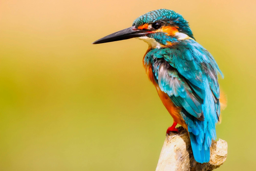

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

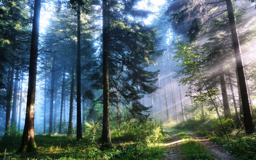

In [8]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

In [9]:
# Downloading 200 examples of each 'bird' and 'forest' photos, and save each group of photos to a different folder
searches = 'forest', 'bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photos'))
  sleep(10) # Pause between searches to avoid over-loading server
  download_images(dest, urls=search_images(f'{o} sun photos'))
  sleep(10)
  download_images(dest, urls=search_images(f'{o} shade photos'))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


Step 2: Train our model

In [10]:
# Some photos might not dowmload correctly which would cause our model training to fail, so we'll remove them
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


33

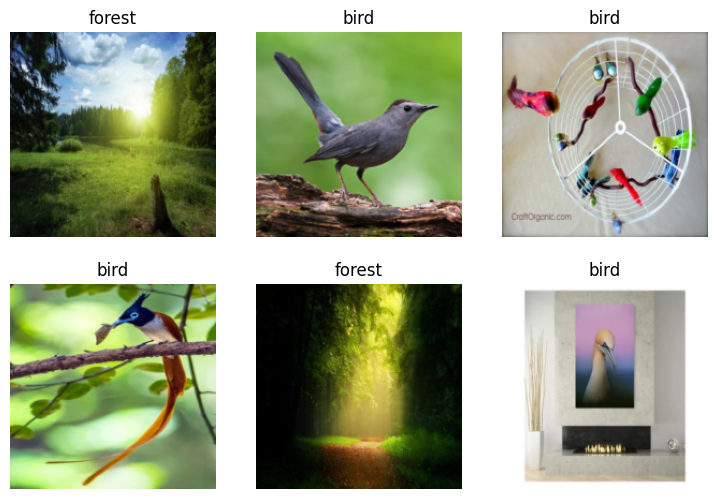

In [11]:
# To trian a model, we'll need DataLoaders
# DataLoaders - an object that contains a training set (images used to create a model) and a validation set (images used to check the accuracy of a model - not used during the training)
# fastai - this is done easily using DataBlock

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Input are images and output are categories
    get_items=get_image_files, # To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split the data into training and validation sets randomly, using 20% of the data for the validation set
    get_y=parent_label, # The labels - y values - are the name of the parent of each file - i.e., the name of the folder they're in, which will be a bird or forest
    item_tfms=[Resize(192, method='squish')] # Before training, resize the image to 192 x 192 pixels by 'squishing' it - as opposed to cropping it
).dataloaders(path)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)
# Fine-tuning a model - we're starting with a model someone else has trained using some other dataset (pretrained model)
# and adjusting the weights a bit so that the model learns to recognise your particular dataset

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.649180,0.154833,0.036530,02:51


epoch,train_loss,valid_loss,error_rate,time
0,0.159237,0.111287,0.027397,03:22
1,0.104290,0.101311,0.027397,03:24
2,0.064312,0.106109,0.036530,03:26


In [13]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
